# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis,
    print_error_df
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_tiny.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_finetuned_1/trainer_output"
SAVE_PATH = "../models/distilbert_finetuned_1/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:create encoded dataframes
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


In [6]:
y_train = encoded_train_dataset['logical_fallacies']

### Model Initialization

In [7]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 1
# num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=True
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "distilbert finetuned")
mlflow.log_params(params)

Active run_id: e192db999371481ca879c04614c3e2c7


In [8]:
num_classes = len(np.unique(y_train))
num_classes

6

In [9]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.798904,0.166667


TrainOutput(global_step=18, training_loss=1.80632570054796, metrics={'train_runtime': 17.535, 'train_samples_per_second': 3.992, 'train_steps_per_second': 1.027, 'total_flos': 9273379368960.0, 'train_loss': 1.80632570054796, 'epoch': 1.0})

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3

                       precision    recall  f1-score   support

           ad_hominem       0.00      0.00      0.00         8
  appeal_to_authority       0.00      0.00      0.00         4
    appeal_to_emotion       0.00      0.00      0.00         5
        false_dilemma       0.00      0.00      0.00         4
faulty_generalization       0.11      0.20      0.14         5
                 none       0.25      1.00      0.40         4

             accuracy                           0.17        30
            macro avg       0.06      0.20      0.09        30
         weighted avg       0.05      0.17      0.08        30



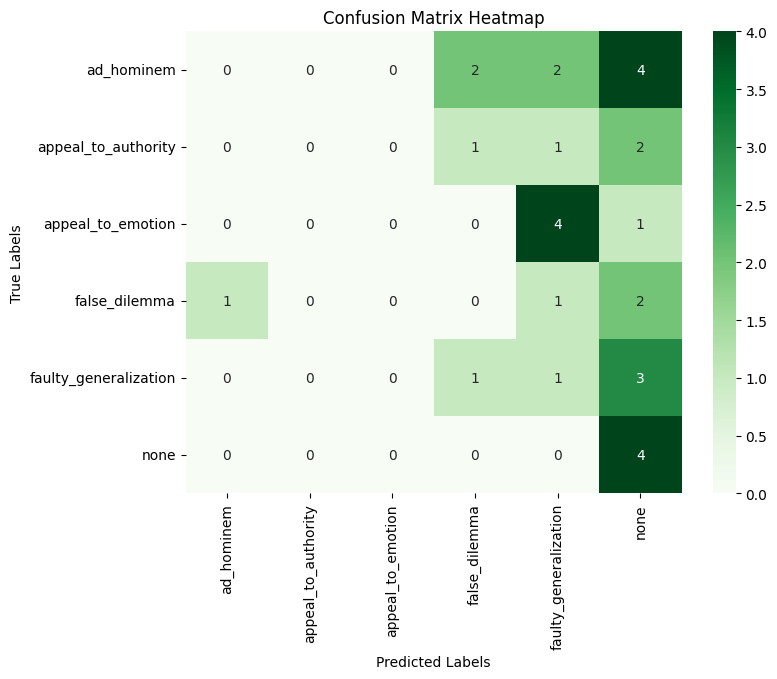

INFO:basic_functions:brier score


Multiclass Brier score: 0.8322347914403974


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3

                       precision    recall  f1-score   support

           ad_hominem       0.50      0.11      0.18        18
  appeal_to_authority       0.00      0.00      0.00         9
    appeal_to_emotion       0.00      0.00      0.00        10
        false_dilemma       0.41      0.64      0.50        11
faulty_generalization       0.26      0.38      0.31        13
                 none       0.27      0.89      0.41         9

             accuracy                           0.31        70
            macro avg       0.24      0.34      0.23        70
         weighted avg       0.28      0.31      0.24        70



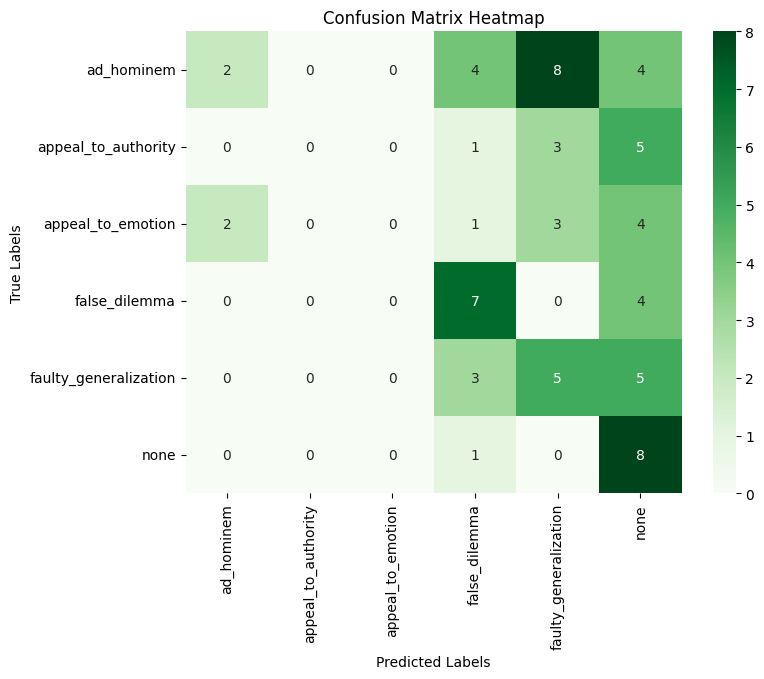

INFO:basic_functions:brier score


Multiclass Brier score: 0.8240622968282466


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [17]:
mlflow.end_run()

🏃 View run distilbert finetuned at: http://127.0.0.1:5001/#/experiments/118053630762497624/runs/e192db999371481ca879c04614c3e2c7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/118053630762497624


### Save model

In [18]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

MlflowException: Path '/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/models/distilbert_finetuned_1/pytorch_model' already exists and is not empty

### Error Analysis

In [19]:
df_error_test = get_error_analysis(test_output, encoded_test_dataset)

In [20]:
# get text, which is predicted false
print_error_df(df_error_test)

Example 0:
Text: This is not going to end well
True Label: 2, Predicted Label: 4
Example 1:
Text: I favor higher salaries for teachers
True Label: 2, Predicted Label: 4
Example 2:
Text: The Chinese only go to Australia to proliferate Whether propaganda or create new settlements They are probably working on a new china town where they carry out covert activity
True Label: 3, Predicted Label: 4
Example 3:
Text: very sick ideas
True Label: 2, Predicted Label: 4
Example 4:
Text: The police seem to be trying to keep track of the statistics regarding street harassment But hopefully they can do more and help these women to feel like their voices are heard The article said an officer for the tourist police said that most people don t complain of Street harassment But maybe this is because they are not there for long periods of time The experts at UNPFA said 90 percent have
True Label: 1, Predicted Label: 5
Example 5:
Text: Holding an election in these conditions is wildly irresponsible My rela

In [21]:
# get dataset, with most false predicted values
df_counts = df_error_test[['dataset', 'true_label', 'pred_label']].groupby(['dataset', 'true_label']).value_counts().reset_index()
df_counts.sort_values('count', ascending=False)

,dataset,true_label,pred_label,count
16,9,2,4,4
5,3,1,5,2
8,3,3,5,2
1,2,0,5,2
10,3,4,5,2
0,1,4,5,1
11,4,0,5,1
15,9,0,5,1
14,8,0,3,1
13,4,0,3,1
